In [1]:
import pandas as pd
import json, random
from helpers import *
import time
from tqdm import tqdm_notebook
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
from dateutil import relativedelta
from datetime import timedelta
import glob
from fa2l import force_atlas2_layout

# Load pages and categories

In [2]:
normal_pages = pd.read_pickle("./Data/normal_pages/normal_pages.pkle")

category_pages = pd.read_pickle("./Data/category_pages/category_pages.pkle")

normal_pages.to_pickle("./Data/normal_pages/normal_pages.pkle")

category_pages.to_pickle("./Data/category_pages/category_pages.pkle")

In [4]:
len(normal_pages)

14050827

# Load links

In [5]:
links = pd.read_csv("./Data/diseases/diseases_edges.csv",sep='\t',comment='#',header=0,names=['linkSource', 'rel','linkTarget'],dtype=str)

## Filter links if they don't link pages (they link categories)

In [6]:
links_copy = links.copy()

In [7]:
indexes_to_drop = []
for i,row in tqdm_notebook(links_copy.iterrows(),total = links_copy.shape[0]):
    if int(row['linkSource']) in normal_pages.index and int(row['linkTarget']) in normal_pages.index:
        links_copy.at[i,'linkSource'] = normal_pages.loc[int(row['linkSource'])]['article']
        links_copy.at[i,'linkTarget'] = normal_pages.loc[int(row['linkTarget'])]['article']
    else:
        indexes_to_drop.append(i)
        
links_copy = links_copy.drop(links_copy.index[indexes_to_drop])

#Drop 'BELONGS_TO' link

In [8]:
links_copy = links_copy.loc[links['rel'] != 'BELONGS_TO']

In [9]:
links_copy.head()

,linkSource,rel,linkTarget
1,Dutch_hypothesis,LINKS_TO,Chronic_obstructive_pulmonary_disease
2,Dutch_hypothesis,LINKS_TO,Asthma
4,Natural_history_of_disease,LINKS_TO,Disease
5,Causes_of_Parkinson\'s_disease,LINKS_TO,Parkinson\'s_disease
6,Causes_of_Parkinson\'s_disease,LINKS_TO,Asymptomatic_carrier


## Filter normal pages if they are redirect

In [10]:
normal_pages_copy = normal_pages.copy()

In [11]:
normal_pages_copy = normal_pages_copy.loc[normal_pages_copy['isRedirect'] == False]

In [12]:
len(normal_pages_copy)

5690369

## First iterative filter to reduce further number of request

In [13]:
filtered_pages, filtered_links = iterative_filter(normal_pages_copy,links_copy)

In [14]:
len(filtered_links)

22949

## Request to get article activity

In [15]:
s = datetime.datetime(year=2015,month=11,day=1)
e = datetime.datetime(year=2018,month=11,day=1)

In [16]:
timer = time.localtime(time.time())
requests = 0
requests_tot = 0
granularity = 'monthly'
user_activity_dict = {}
to_drop = []

for index,row in tqdm_notebook(filtered_pages.iterrows(),total = filtered_pages.shape[0]):
    requests +=1
    requests_tot+=1
    values = getUserActivity(article=row['article'],granularity=granularity,start=s,end=e)
    
    if (len(values) <= int(monthdelta(s,e) - 1) and granularity == 'monthly') or (len(values) <= int((e - s).days) and granularity == 'daily'):
            
        print("drop "+ row['article'])
        to_drop.append(index)
        filtered_pages.drop(index, inplace=True)
        
    else:
        user_activity_dict[index] = values
        
    #to fit the limit of 100req/s    
    current_time = time.localtime(time.time())
    time_elapsed_sec = current_time[5] - timer[5]
    time_elapsed_min = current_time[4] - timer[4]
    if  time_elapsed_min < 1 and time_elapsed_sec < 0 and requests >= 100:
        time.sleep(max(time_elapsed_sec,0))
        timer = time.localtime(time.time())
        requests = 0
    elif time_elapsed_min >= 1 and time_elapsed_sec >=0:
        timer = time.localtime(time.time())
        requests = 0

drop Huntington\'s_disease
drop Crohn\'s_disease
drop Morvan\'s_syndrome
drop Koch\'s_postulates
drop Idiopathic_disease
drop Hashimoto\'s_thyroiditis
drop Sheehan\'s_syndrome
drop Traveler\'s_diarrhea
drop Battle\'s_sign
drop Zieve\'s_syndrome
drop Wooden_chest_syndrome
drop Swimmer\'s_itch
drop Freshers\'_Flu
drop Winterbottom\'s_sign
drop Nelson\'s_syndrome
drop Surfer\'s_ear
drop Gradenigo\'s_syndrome
drop Valentino\'s_syndrome
drop Tyzzer\'s_disease
drop Factitious_disorder_imposed_on_another
drop Hamman\'s_syndrome
drop HIV/AIDS
drop Distal_trisomy_10q
drop Golfer\'s_vasculitis
drop Hutchinson\'s_triad
drop Sneddon\'s_syndrome
drop Pseudo-Cushing\'s_syndrome
drop Majewski\'s_polydactyly_syndrome
drop Wissler\'s_syndrome
drop Paget\'s_abscess
drop Jansen\'s_metaphyseal_chondrodysplasia
drop Alvarez\'_syndrome
drop Wilson\'s_temperature_syndrome
drop Barton\'s_fracture
drop Ramsay_Hunt_syndrome_type_1
drop Anterior_compartment_syndrome
drop Wartenberg\'s_migratory_sensory_neuropath

In [17]:
filtered_pages, filtered_links = iterative_filter(filtered_pages,filtered_links)

In [18]:
filtered_links.loc[43].values

array(['Causes_of_seizures', 'LINKS_TO', 'Down_syndrome'], dtype=object)

In [19]:
len(filtered_pages)

1385

## Create Graph

In [18]:
def createGraph20(nodes, edges):
    """
    Method to create a networkx directed graph from articles node already filtered in categories_filtered
    articles: the wikipedia articles in dataframe ['article']

    categories_filtered: wikipedia articles with their category ['article','categories_filtered'] where 'article' is the index
    categories_filtered have to contain only the node with category you want to appear on the graph.

    links: the hyperlinks between wikipedia articles in form ['linkSource', 'linkTarget']

    return newly created networkx.DiGraph
    """

    #Create graph with networkx
    tup = [[x[0],x[2]] for x in edges.values]
    G = nx.Graph()
    G.add_edges_from(tup)
    return G

In [19]:
G = createGraph20(filtered_pages, filtered_links)

## Color node with community detection

In [20]:
from networkx.algorithms.community import k_clique_communities,girvan_newman
from networkx.algorithms.community import greedy_modularity_communities, label_propagation_communities

In [21]:
clique = list(greedy_modularity_communities(G))

In [22]:
len(clique)

19

In [24]:
buckets = len(clique)
cmap=plt.cm.get_cmap('Dark2')
color_dict = {}
color_dict_edge = {}
for i,row in filtered_pages.iterrows():
    for b in range(buckets):
        if row['article'] in clique[b] :
            color_dict[row['article']] = (int(cmap(b)[0]*255),int(cmap(b)[1]*255),int(cmap(b)[2]*255),1.0)
            color_dict_edge[row['article']] = (int(cmap(b)[0]*255),int(cmap(b)[1]*255),int(cmap(b)[2]*255),0.2)

## Compute positions with specific layout

In [215]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=0.5,
                          # Tuning
                          scalingRatio=600.0,
                          strongGravityMode=False,
                          gravity=40.0,
                          # Log
                          verbose=False)

In [27]:
def layout2(G, algorithm, fa=None):
	"""Function that apply a layout on graph and return the new positions of nodes
		G: the networkx graph.
		algorithm: kamada_kawai or ForceAtlas2"""
	
	positions = {}
	if algorithm == 'kamada_kawai':
		positions = nx.kamada_kawai_layout(G)

	elif algorithm == 'ForceAtlas2' and fa != None:
		"""
        Example for fa argument
        forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=False,
                          barnesHutTheta=1.2,
                          # Tuning
                          scalingRatio=5.0,
                          strongGravityMode=False,
                          gravity=50.0,
                          # Log
                          verbose=False)"""
		positions = fa.forceatlas2_networkx_layout(G, pos=None, iterations=100)
	return positions

In [216]:
positions = layout2(G, algorithm='ForceAtlas2',fa=forceatlas2)

In [217]:
x_mean = 0
y_mean = 0
x_std = 0
y_std = 0
for k,pos in positions.items():
    x_mean += pos[0]
    y_mean += pos[1]
x_mean /= len(positions)
y_mean /= len(positions)

for k,pos in positions.items():
    x_std += abs(pos[0]-x_mean)
    y_std += abs(pos[1]-y_mean)

x_std = np.sqrt(x_std/len(positions))
y_std = np.sqrt(y_std/len(positions))

In [218]:
#positions = nx.spring_layout(G,center=[0,0],seed=0)

In [219]:
filtered_pages['coord'] = filtered_pages['article'].map(positions)

## Normalize user activity

In [32]:
user_activity_df = create_df_activity(user_activity_dict)

In [33]:
normalized_user_activity_df = normalize_activity(user_activity_df, factor=30, byColumn=False)

In [34]:
# Create dataframe that contain the mean of each line
user_activity_df_mean = normalized_user_activity_df.copy()
user_activity_df_mean['mean'] = user_activity_df_mean.mean(axis=1)
user_activity_df_mean['std'] = normalized_user_activity_df.std(axis=1)

## Add French names

In [36]:
timer = time.localtime(time.time())
requests_ = 0
requests_tot = 0
language_code = "fr"
lang_dict = {}
user_activity_dict_fr = {}

for index,row in tqdm_notebook(filtered_pages.iterrows(),total = filtered_pages.shape[0]):
    requests_ +=2
    requests_tot+=2
    new_title = getArticleName(row['article'],language_code)
    found = False
    if new_title != "":
        values = getUserActivity(article=new_title,project=language_code+".wikipedia.org",granularity=granularity,start=s,end=e)
        if not((len(values) <= int(monthdelta(s,e) - 1) and granularity == 'monthly') or (len(values) <= int((e - s).days) and granularity == 'daily')):
            user_activity_dict_fr[index] = values
            lang_dict[row['article']] = new_title
            found = True
    
    if not found:
        lang_dict[row['article']] = "unknown"
        

In [37]:
filtered_pages['article_'+language_code] = filtered_pages['article'].map(lang_dict)

In [38]:
user_activity_df_fr = create_df_activity(user_activity_dict_fr)

In [39]:
normalized_user_activity_df_fr = normalize_activity(user_activity_df_fr, factor=30, byColumn=False)

In [40]:
user_activity_df_mean_fr = normalized_user_activity_df_fr.copy()
user_activity_df_mean_fr['mean'] = user_activity_df_mean_fr.mean(axis=1)
user_activity_df_mean_fr['std'] = normalized_user_activity_df_fr.std(axis=1)

In [41]:
filtered_pages.loc[filtered_pages['article_fr'] == "Arthrite"]

,article,isRedirect,isNew,coord,article_fr
id,,,,,
1776,Arthritis,False,False,"(2621.572990998913, 2159.9047774845385)",Arthrite


## Build Final JSON

In [42]:
filtered_pages.loc[15538]

article                      Inclusion_body_myositis
isRedirect                                     False
isNew                                          False
coord         (113.6733567498928, 2310.434146286453)
article_fr                                   unknown
Name: 15538, dtype: object

In [43]:
def parse_article_title(title):
    return urllib.parse.unquote(title).replace('_',' ')
def parse_color(color):
    return "rgba"+str(color).replace(' ','')

In [220]:
graph_data = { 'nodes': [], 'edges': [] }

for i,row in filtered_pages.iterrows():
    
    x,y = w_stye_coordinate()
    
    to_be_added = {}
    for j in range(len(normalized_user_activity_df.loc[i])):
        to_be_added[str(j)+"_size"] = normalized_user_activity_df.loc[i][j]
        if row['article_fr'] != "unknown":
            to_be_added[str(j)+"_size_fr"] = normalized_user_activity_df_fr.loc[i][j]

    to_be_added['label'] = parse_article_title(row['article'])
    to_be_added['label_en'] = parse_article_title(row['article'])
    to_be_added['label_fr'] = parse_article_title(row['article_fr'])
    to_be_added['x'] = x
    to_be_added["y"] = y
    to_be_added["id"]= parse_article_title(row['article'])
    to_be_added['id_en'] = parse_article_title(row['article'])
    to_be_added['id_fr'] = parse_article_title(row['article_fr'])
    to_be_added["attributes"]= {"category":'Unknown'}
    to_be_added["user_activity"]= user_activity_dict[i]
    if row['article_fr'] != "unknown":
        to_be_added["user_activity_fr"]= user_activity_dict_fr[i]
        to_be_added["activity_mean_fr"]= user_activity_df_mean_fr.loc[i]['mean']
        to_be_added["activity_std_fr"]= user_activity_df_mean_fr.loc[i]['std']
    to_be_added["color"]= 'rgb(30,30,30)'
    to_be_added["originalColor"]= parse_color(color_dict[row['article']])
    #"size": 0 if(user_activity_dict[i][0][0]==0) else (np.log(user_activity_dict[i][0][0]))
    to_be_added["size"]= 10
    to_be_added["square_x"]= x
    to_be_added["square_y"]= y
    to_be_added["square_size"]= 10
    to_be_added["square_color"]= 'rgb(30,30,30)'
    to_be_added["correct_x"]= (row['coord'][0] - x_mean)/x_std
    to_be_added["correct_y"]= (row['coord'][1] - y_mean)/y_std
    to_be_added["correct_size"]= normalized_user_activity_df.loc[i][0]
    to_be_added["activity_mean"]= user_activity_df_mean.loc[i]['mean']  
    to_be_added["activity_std"]= user_activity_df_mean.loc[i]['std']
    
    #to_be_added["correct_color"]= row['color']
    to_be_added["correct_color"]= parse_color(color_dict[row['article']])
    graph_data['nodes'].append(to_be_added)

for i,row in filtered_links.iterrows():
    graph_data['edges'].append({
            "id": str(i),
            "source": parse_article_title(row['linkSource']),
            "target": parse_article_title(row['linkTarget']),
            "attributes" : {},
            "color": parse_color(color_dict_edge[row['linkSource']]),
            "originalColor": parse_color(color_dict_edge[row['linkSource']]),
            #"color": "rgb(30,30,30)",
            #"originalColor": "rgb(30,30,30)",
            "size": 0.1,
            "type": 'curve'
        })

In [221]:
save_graph_json('../raffiot.github.io/raffiot.github.io/diseases/diseases_2depth_en_fr.json',graph_data)

filtered_links.to_pickle("./Data/diseases/filtered_links_"+s.strftime("%Y-%m-%d")+"_"+e.strftime("%Y-%m-%d")+"_"+granularity+".pkle")

In [46]:
len(filtered_links)

20460

## Analysis

In [47]:
from matplotlib.pyplot import figure

### Maladie de Sanfillipo

In [48]:
sf = filtered_pages.loc[filtered_pages['article_fr'] == 'Maladie_de_Sanfilippo']

In [49]:
sanfillipo_serie = user_activity_dict_fr[sf.index[0]]

In [50]:
def transform_activity(serie):
    x = []
    y = []
    for i in serie:
        x.append(i[1][0:7])
        y.append(i[0])
    return x,y

In [51]:
x,y = transform_activity(sanfillipo_serie)

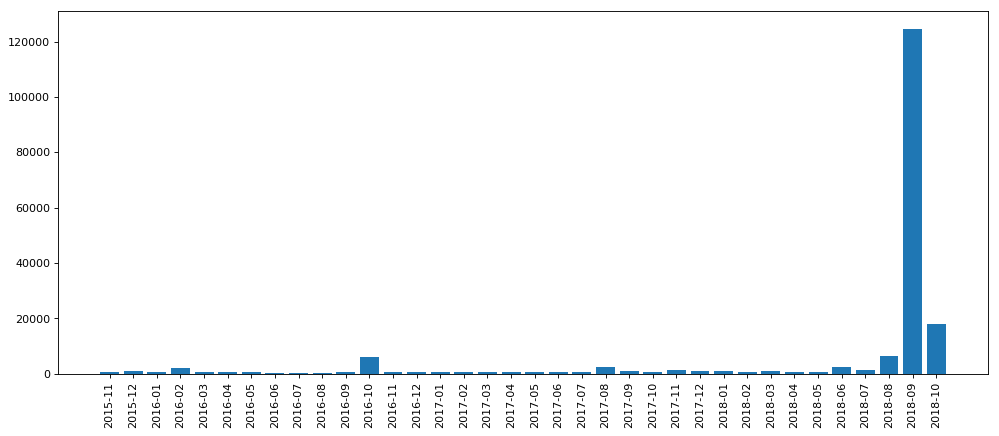

In [52]:
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.xticks(rotation=90)
plt.bar(x,y)
plt.savefig("../raffiot.github.io/raffiot.github.io/images/sanfilippo")
#plt.show()

In [53]:
activity_peak = sanfillipo_serie[-2]

In [54]:
activity_peak

[124623, '2018-09-01T00:00:00']

In [55]:
np.mean(y)

5099.083333333333

In [56]:
activity_peak[0]/np.mean(y)

24.44027521286506

### Gastro etc...

In french we observe the patern

In [154]:
filtered_pages.loc[filtered_pages['article'] == 'Tonsillitis']

,article,isRedirect,isNew,coord,article_fr
id,,,,,
903516,Tonsillitis,False,False,"(4133.4332696435085, 3781.8728377623434)",Angine


In [153]:
filtered_pages.loc[filtered_pages['article'] == 'Acute_bronchitis']

,article,isRedirect,isNew,coord,article_fr
id,,,,,
302755,Acute_bronchitis,False,False,"(4334.745940315789, -975.9583666884442)",Bronchite_aigu%C3%AB


In [157]:
angine = filtered_pages.loc[filtered_pages['article'] == 'Tonsillitis']
rhume = filtered_pages.loc[filtered_pages['article_fr'] == 'Rhume']
bronch = filtered_pages.loc[filtered_pages['article'] == 'Acute_bronchitis']

In [158]:
angine_serie = user_activity_dict_fr[angine.index[0]]
rhume_serie = user_activity_dict_fr[rhume.index[0]]
bronch_serie = user_activity_dict_fr[bronch.index[0]]

In [159]:
x2,y2 = transform_activity(angine_serie)
x2,y4 = transform_activity(rhume_serie)
x2,y5 = transform_activity(bronch_serie)

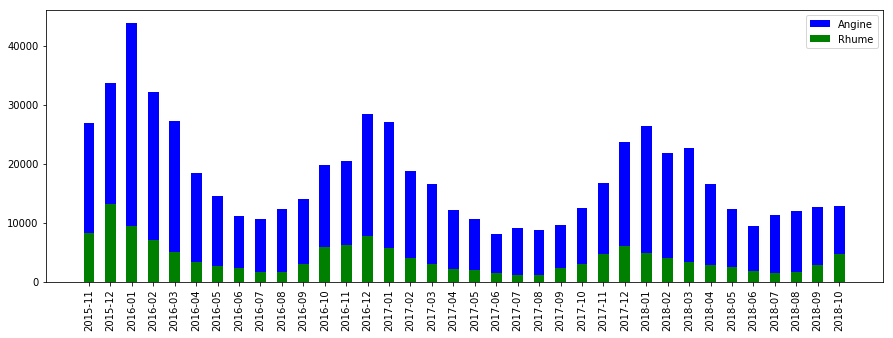

In [174]:
fig, ax = plt.subplots()
fig.set_size_inches((15,5))
plt.xticks(rotation=90)
angine_ax = ax.bar(x, y2,width=0.5,color='b')
rhume_ax = ax.bar(x, y5,width=0.5,color='g')
#bronch_ax = ax.bar(x, y5,width=0.5,color='r')
ax.legend((angine_ax[0], rhume_ax[0], bronch_ax[0]), ('Angine','Rhume'))
#plt.show()
plt.savefig("../raffiot.github.io/raffiot.github.io/images/winter_diseases")

In [71]:
new_list = [x+width for x in my_list]

TypeError: unsupported operand type(s) for +: 'range' and 'int'

In [79]:
range(width,len(x)+width)

range(1, 37)

In [78]:
range(0,len(x))

range(0, 36)

In [84]:
a = np.arange(len(x))

In [94]:
plt.figure(figsize=(20, 3))  # width:20, height:3
plt.bar(range(len(my_dict)), my_dict.values(), align='edge', width)

SyntaxError: positional argument follows keyword argument (<ipython-input-94-b416af3045b7>, line 2)

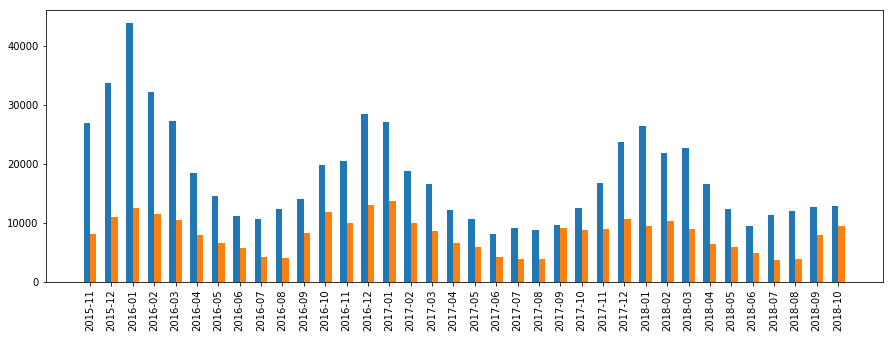

In [112]:
fig, ax = plt.subplots()
width = 0.3
fig.set_size_inches((15,5))
ax.bar(a, y2, width, align = 'center')
ax.bar(a+width, y4, width, align = 'center')
ax.set_xticks(a + width / 2)
ax.set_xticklabels(x)
plt.xticks(rotation=90)
#ax.set_xticks(range(0,len(x))) # sets the x-ticks to the middle of the cluster of bars
#ax.xaxis_date()
plt.show()

In english

In [169]:
angine_serie_en = user_activity_dict[angine.index[0]]
rhume_serie_en = user_activity_dict[rhume.index[0]]
bronch_serie_en = user_activity_dict[bronch.index[0]]

In [170]:
x2,y6 = transform_activity(angine_serie_en)
x2,y7 = transform_activity(rhume_serie_en)
x2,y8 = transform_activity(bronch_serie_en)

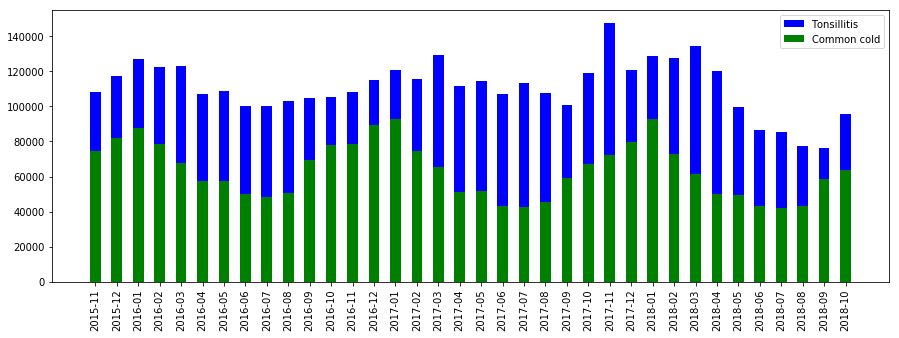

In [172]:
fig, ax = plt.subplots()
fig.set_size_inches((15,5))
plt.xticks(rotation=90)
angine_ax = ax.bar(x, y6,width=0.5,color='b')
rhume_ax = ax.bar(x, y7,width=0.5,color='g')
#bronch_ax = ax.bar(x, y5,width=0.5,color='r')
ax.legend((angine_ax[0], rhume_ax[0]), ('Tonsillitis','Common cold'))
#plt.show()
plt.savefig("../raffiot.github.io/raffiot.github.io/images/winter_diseases_en")

In [210]:
personnes =[
    ("Grand papa","M"),
    ("Mamie",'F'),
    ("Felix",'M'),
    ("Agnes",'F'),
    ("Pierre-Jean", 'M', 'eve'),
    ("Eva",'F'),
    ("Eve",'F'),
    ("Marc",'M'),
    ("Christophe",'M'),
    ("Paul",'M'),
    ("Raphael",'M')
]

In [189]:
copy_personne = {}
for k,v in personnes.items():
    copy_personne[k]= v

In [211]:
def assigner_personne(current_p,list_):
    if len(list_) == 1:
        return list_[0]
    else:
        for i,p in enumerate(list_):
            if current_p == None or current_p[1] != p[1]:
                assigned = assigner_personne(p,list_[:i] + list_[i+1:])
                print(assigned)
                return p
    print("impossible")

In [212]:
assigner_personne(None,personnes)        

impossible
None
('Christophe', 'M')
('Eve', 'F')
('Marc', 'M')
('Eva', 'F')
('Pierre-Jean', 'M', 'eve')
('Agnes', 'F')
('Felix', 'M')
('Mamie', 'F')


('Grand papa', 'M')